I do Fisher exact tests on junctions we already know are alternatively spliced from short reads just to see what concordance looks like.

A few genes have p-values that aren't 1, however none have a value below 0.05. The x-axis is arbitrarily indexed.

In [13]:
setwd('~/bme')
wt_counts = read.table('junction_counts_long.wt.6.txt')
mt_counts = read.table('junction_counts_long.6.txt')
wt_counts$V1 = as.character(wt_counts$V1)
mt_counts$V1 = as.character(mt_counts$V1)
head(cbind(wt_counts, mt_counts))

V1,V2,V3,V4,V5,V1,V2,V3,V4,V5
PCK2,24099721,24099994,0,1,PCK2,24099721,24099994,2,1
PCK2,24099721,24102752,0,1,PCK2,24099721,24102752,1,1
"GOLGA6L5,RP11-182J1.12",84513303,84513966,0,1,"GOLGA6L5,RP11-182J1.12",84513303,84513966,0,1
"GOLGA6L5,RP11-182J1.12",84513331,84513966,0,1,"GOLGA6L5,RP11-182J1.12",84513331,84513966,0,1
DDHD2,38237628,38238106,0,1,DDHD2,38237628,38238106,0,1
DDHD2,38237628,38238088,1,1,DDHD2,38237628,38238088,0,1


In [15]:
current_gene = ''
genes = c()
pvals = c()  # for collecting results
sigrows = c()
for (row in 1:(nrow(wt_counts))+1) {  # looping through table and pulling out rows with shared gene names to do fisher tests on
    if (row == nrow(wt_counts)+1 || wt_counts[row, 1] != current_gene | nchar(current_gene)==0) {
        if (nchar(current_gene) > 0 && (nrow(wtinfo) > 1)) {
            for (i in 1:(nrow(wtinfo))) {
                for (j in i:nrow(wtinfo)) {
                    ctable = matrix(unlist(c(wtinfo[c(i,j),4], mtinfo[c(i,j),4])), nrow=2)
                    if (sum(ctable) != 0 && wtinfo[i,2] == wtinfo[j,2] | wtinfo[i,3] == wtinfo[j,3]) {  
                        # extra check for genes with multiple alt splice junctions, making sure gene and junction 5' end match
                        if (fisher.test(ctable)$p.value < 0.6) {
                            sigrows = c(sigrows, row-nrow(wtinfo)+i-1, row-nrow(wtinfo)+j-1)
                        }
                        pvals = c(pvals, fisher.test(ctable)$p.value)
                        genes = c(genes, current_gene)
                    }
                }
                
            }
        }
        current_gene = wt_counts[row, 1]
        wtinfo = wt_counts[row,]
        mtinfo = mt_counts[row,]
    } else {
        wtinfo = rbind(wtinfo, wt_counts[row,])
        mtinfo = rbind(mtinfo, mt_counts[row,])
    }
}

In [120]:
sigrows = sort(unique(sigrows))
head(cbind(wt_counts[sigrows,], mt_counts[sigrows,]))

,V1,V2,V3,V4,V5,V1,V2,V3,V4,V5
17,ERGIC3,35556272,35556990,0,1,ERGIC3,35556272,35556990,0,1
18,ERGIC3,35556749,35556954,0,1,ERGIC3,35556749,35556954,0,1
19,ERGIC3,35556272,35556954,0,1,ERGIC3,35556272,35556954,6,1
31,FKBP3,45130801,45134348,2,1,FKBP3,45130801,45134348,10,1
32,B3GAT3,62620672,62621865,0,1,B3GAT3,62620672,62621865,4,1
40,SRSF11,70228556,70232267,2,1,SRSF11,70228556,70232267,12,1


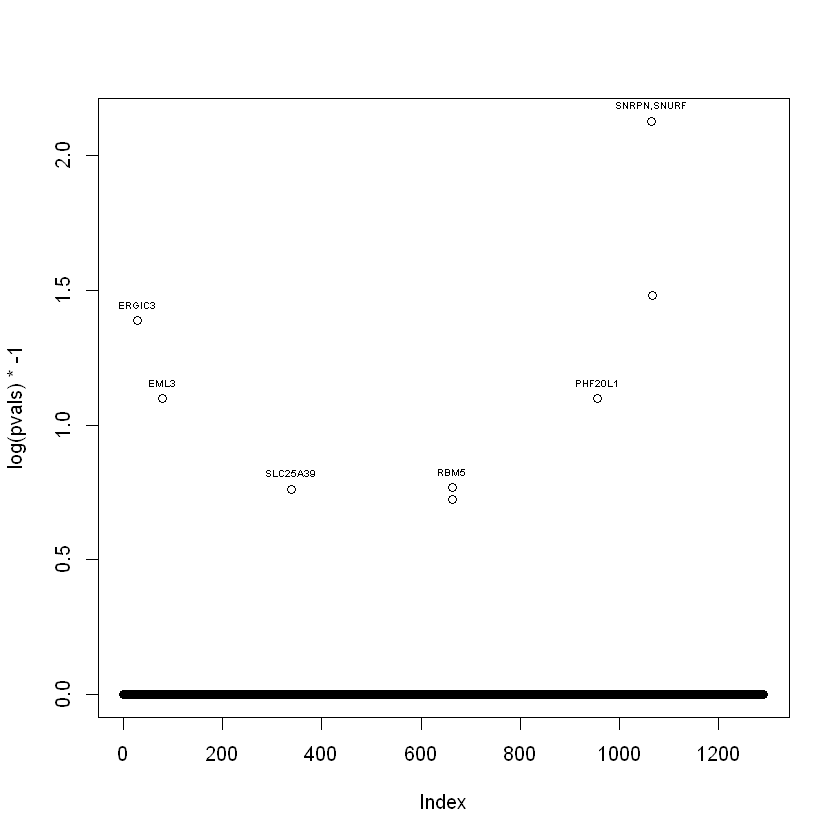

In [16]:
plot(log(pvals)*-1)
df = data.frame(g=genes, p=pvals)
df$pos = 1:nrow(df)
df = df[df$p < 0.6,]
newdf = df[1,]
for (row in 2:nrow(df)) {
    if (!df[row,1] %in% newdf[,1]) {
        newdf = rbind(newdf, df[row,])
    } else if (any((df[row,2]+.01) <= newdf[newdf$g == df[row,1],2])) {
        newdf = rbind(newdf, df[row,])
    }
}
text(newdf$pos, log(newdf$p)*-1+.06, labels=newdf$g, cex=0.5)  # names above points
abline(h=log2(0.05))

I use Jeltje's bedfile of corrected junctions and the junction counts in there and do lots of fisher tests. I'm looking specifically at 3' SS alterations, so I compare counts for different 3' SSs in the mutant and wildtype for junctions with the same 5' SS. Jeltje mentioned that the strand doesn't carry meaning in her bedfile, so I repeat this analysis treating "3'" as 5' SSs.

In [21]:
setwd('~/bme')
mtalt = read.table('altsplicejunction_counts.txt')
colnames(mtalt) = c('mtchrom', 'mt5', 'mt3', 'counts')
wtalt = read.table('altsplicejunction_counts.wt.txt')
together = mtalt
together$wt = wtalt$V4[match(mtalt$mt5, wtalt$V2)]
together$wtchrom = wtalt$V1[match(mtalt$mt5, wtalt$V2)]  # sanity check
together$mtchrom = as.character(together$mtchrom)
together$wtchrom = as.character(together$wtchrom)
together = together[!is.na(together$wt) & together$wtchrom == together$mtchrom,]
head(together)  # data frame containing junction counts for both mutant and wildtype

,mtchrom,mt5,mt3,counts,wt,wtchrom
20,chrY,1389707,1391934,1,10,chrY
21,chrY,1389707,1391947,1,10,chrY
22,chrY,1389707,1391918,54,10,chrY
78,chrX,154399376,154399527,1,1,chrX
79,chrX,154399376,154399520,5,1,chrX
80,chrX,154399376,154399506,101,1,chrX


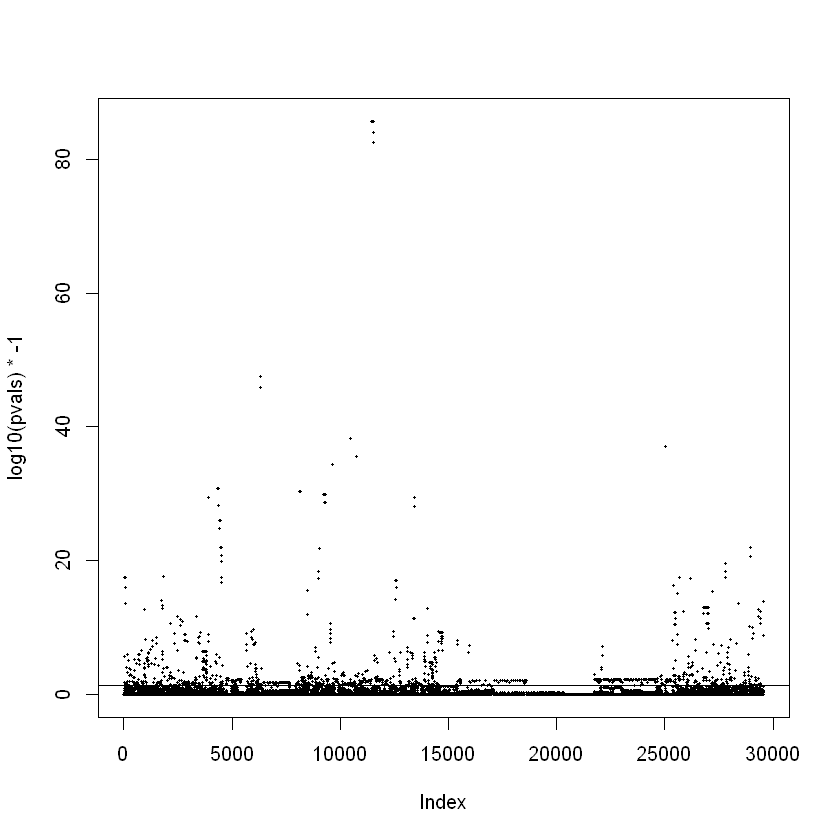

In [15]:
current_gene = paste0(together[1,1],':',together[1,2])
info = together[1,]
genes = c()
pvals = c()
for (row in 2:nrow(together)) {
    nameinit = paste0(together[row,1],':',together[row, 2])
    if (nameinit != current_gene) {
        for (i in 1:(nrow(info)-1)) {
            for (j in (i+1):nrow(info)) {
                ctable = matrix(unlist(c(info[c(i,j),4], info[c(i,j),5])), nrow=2)
                if (sum(ctable) != 0) {
                    pvals = c(pvals, fisher.test(ctable)$p.value)
                    genes = c(genes, current_gene)
                }
            }    
        }
        current_gene = nameinit
        info = together[row,]
    } else {
        info = rbind(info, together[row,])
    }
}
rgenes = genes[pvals < 0.2]
rpvals = pvals[pvals < 0.2]
plot(log10(pvals)*-1, pch=16, cex=0.3)
# text(1:length(rpvals), log10(rpvals)*-1+.03, labels=rgenes, cex=0.5)  # names above points
abline(h=log10(0.05)*-1)


Above: every point is the result of one fisher test between alternative junction events. These are only considering 3' splice site alterations, so if you look at the the mutant 5' position column (together$mt5), comparisons are done within a group of junctions sharing the same 5' end.

Below: Like the plot above, but instead anchoring at the 3' ends. Some of these junctions could still be technically 5' end-anchored since Jeltje said the counts were done without regard to strand and the bedfile of junctions does not have strand information.

,mtchrom,mt5,mt3,counts,wt,wtchrom
27843,chr9,18467,24870,1,1,chr9
27844,chr9,24618,24870,1,1,chr9
27845,chr9,18472,24870,3,1,chr9
2082,chr12,18459,26820,1,1,chr12
2083,chr12,18464,26820,3,1,chr12
2084,chr12,26568,26820,1,1,chr12


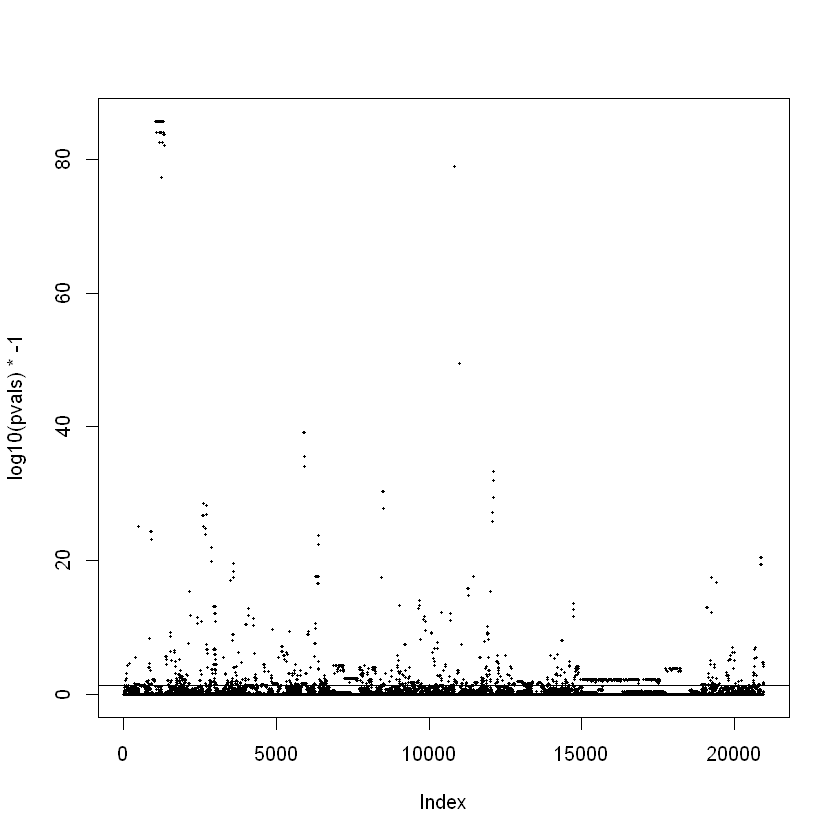

In [12]:
setwd('~/bme')
mtalt = read.table('altsplicejunction_counts.3.txt')   # anchored at the 3' site, aka the greater junction coordinate
colnames(mtalt) = c('mtchrom', 'mt5', 'mt3', 'counts')
wtalt = read.table('altsplicejunction_counts.3.wt.txt')
together = mtalt
together$wt = wtalt$V4[match(mtalt$mt3, wtalt$V3)]
together$wtchrom = wtalt$V1[match(mtalt$mt3, wtalt$V3)]  # sanity check
together$mtchrom = as.character(together$mtchrom)
together$wtchrom = as.character(together$wtchrom)
together = together[order(together$mt3),]
together = together[!is.na(together$wt) & together$wtchrom == together$mtchrom,]
head(together)  # data frame containing junction counts for both mutant and wildtype
current_gene = paste0(together[1,1],':',together[1,3])
info = together[1,]
genes = c()
pvals = c()
for (row in 2:nrow(together)) {
    nameinit = paste0(together[row,1],':',together[row, 3])
    if (nameinit != current_gene) {
        for (i in 1:(nrow(info)-1)) {
            for (j in (i+1):nrow(info)) {
                ctable = matrix(unlist(c(info[c(i,j),4], info[c(i,j),5])), nrow=2)
                if (sum(ctable) != 0) {
                    pvals = c(pvals, fisher.test(ctable)$p.value)
                    genes = c(genes, current_gene)
                }
            }    
        }
        current_gene = nameinit
        info = together[row,]
    } else {
        info = rbind(info, together[row,])
    }
}
rgenes = genes[pvals < 0.2]
rpvals = pvals[pvals < 0.2]
plot(log10(pvals)*-1, pch=16, cex=0.3)
abline(h=log10(0.05)*-1)


<b> From here on starts analysis that actually makes sense :D </b> <br>
Jeltje modified her script to be able to take in a genome and infer strand. So now I am plotting alternative 3' splice sites that are really 3' splice sites being altered.

Warning message in `[<-.factor`(`*tmp*`, is.na(chrvec), value = structure(c(NA, :
"invalid factor level, NA generated"Warning message in `[<-.factor`(`*tmp*`, is.na(chrvec), value = structure(c(24L, :
"invalid factor level, NA generated"Warning message in `[<-.factor`(`*tmp*`, is.na(chrvec), value = structure(c(NA, :
"invalid factor level, NA generated"

,alljuncs,intron5,intron3,wtcounts,mtcounts,chr
8736,51577-47537,51577,47537,0,2,chr16
16572,123236-122070,123236,122070,2,2,chr9
16706,134998-123434,134998,123434,0,1,chr9
16429,154728-152058,154728,152058,0,2,chr9
16638,172100-168892,172100,168892,1,0,chr9
16639,172100-164017,172100,164017,2,2,chr9


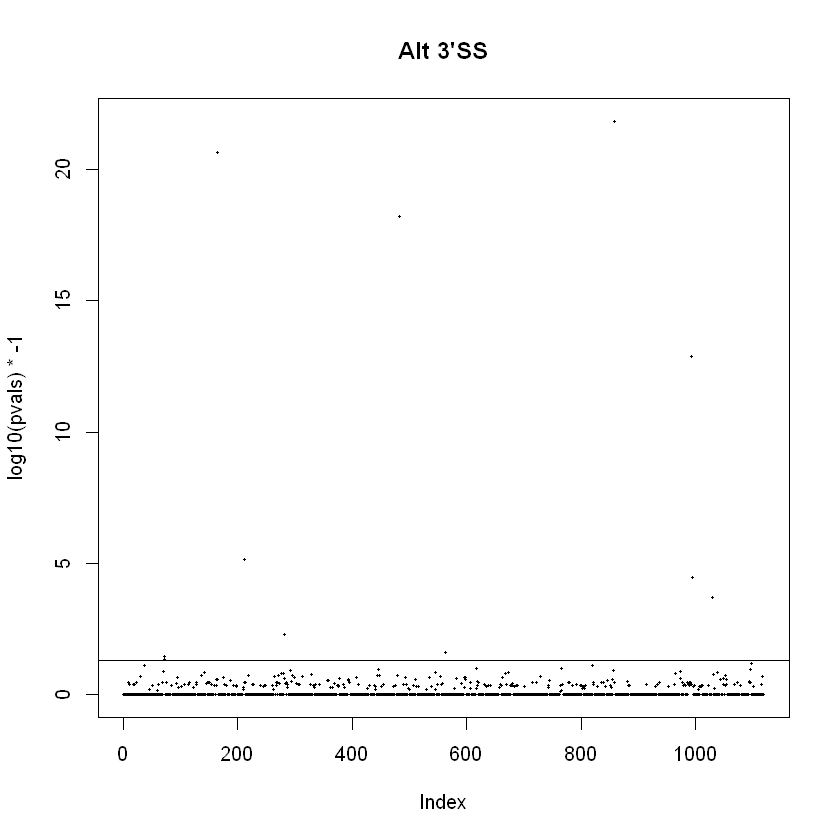

In [35]:
setwd('~/bme/jupyter_data')
mtalt = read.table('altsplicejunction_counts.txt')
mtaltrev = read.table('altsplicejunction_counts.rev.txt')  # 3' ss alterations on the minus strand
colnames(mtalt) = c('mtchrom', 'mt5', 'mt3', 'mtcounts')
colnames(mtaltrev) = c('mtchrom', 'mt5', 'mt3', 'mtcounts')
wtalt = read.table('alt3primess_counts.wt.txt')
wtaltrev = read.table('alt3primess_counts.wt.rev.txt')

wtaltrev$temp = wtaltrev[,2]
wtaltrev[,2] = wtaltrev[,3]
wtaltrev[,3] = wtaltrev$temp

mtaltrev$temp = mtaltrev[,2]
mtaltrev[,2] = mtaltrev[,3]
mtaltrev[,3] = mtaltrev$temp

alljuncs = unique(c(paste0(mtalt[,2],'-',mtalt[,3]), paste0(wtalt[,2],'-', wtalt[,3]), paste0(mtaltrev[,2],'-',mtaltrev[,3]),
             paste0(wtaltrev[,2],'-',wtaltrev[,3])))
junctions = data.frame(alljuncs)
junctions$intron5 = as.numeric(substr(alljuncs,1,regexpr('-', alljuncs)-1))
junctions$intron3 = as.numeric(substr(alljuncs,regexpr('-',alljuncs)+1,nchar(alljuncs)))
wtcounts = wtalt[,4][match(alljuncs, paste0(wtalt[,2],'-',wtalt[,3]))]
wtcounts[is.na(wtcounts)] = wtaltrev[,4][match(alljuncs, paste0(wtaltrev[,2],'-',wtaltrev[,3]))][is.na(wtcounts)]
junctions$wtcounts = wtcounts
# print(sum(is.na(junctions$wtcounts)))
junctions$wtcounts[is.na(junctions$wtcounts)] = 0

mtcounts = mtalt[,4][match(alljuncs, paste0(mtalt[,2],'-',mtalt[,3]))]
mtcounts[is.na(mtcounts)] = mtaltrev[,4][match(alljuncs, paste0(mtaltrev[,2],'-',mtaltrev[,3]))][is.na(mtcounts)]
junctions$mtcounts = mtcounts
junctions$mtcounts[is.na(junctions$mtcounts)] = 0

chrvec =  wtalt[,1][match(alljuncs, paste0(wtalt[,2],'-',wtalt[,3]))]
chrvec[is.na(chrvec)] = wtaltrev[,1][match(alljuncs, paste0(wtaltrev[,2],'-',wtaltrev[,3]))][is.na(chrvec)]
chrvec[is.na(chrvec)] = mtalt[,1][match(alljuncs, paste0(mtalt[,2],'-',mtalt[,3]))][is.na(chrvec)]
chrvec[is.na(chrvec)] = mtaltrev[,1][match(alljuncs, paste0(mtaltrev[,2],'-',mtaltrev[,3]))][is.na(chrvec)]
junctions$chr = chrvec

junctions = junctions[!is.na(chrvec),]  # 2 is the min number of reads between both samples
junctionsold = junctions
junctions[,5] = round(sum(junctions[,4])/sum(junctions[,5])*junctions[,5])

junctions = junctions[rowSums(junctionsold[,c(4,5)]) > 1,]

junctions = junctions[order(junctions[,2]),]

junctions[1:6,]  # data frame containing junction counts for both mutant and wildtype

current_gene = paste0(junctions[1,6],':',junctions[1,2])
info = junctions[1,]
genes = c()
pvals = c()
dpsi = c()
allpvals = c()
for (row in 2:nrow(junctions)) {
    nameinit = paste0(junctions[row,6],':',junctions[row, 2])
    if (nameinit != current_gene ) {
        if (nrow(info) > 1) {
            best_dpsi = 0
            best_pval = 1
            for (i in 1:(nrow(info)-1)) {
                for (j in (i+1):nrow(info)) {
                    ctable = matrix(unlist(c(info[c(i,j),4], info[c(i,j),5])), nrow=2)
                    if (sum(ctable) != 0) {
                        pval = fisher.test(ctable)$p.value
                        allpvals = c(allpvals, pval)
                        if (pval < best_pval) {
                            best_pval = pval
                            best_dpsi = abs(info[i, 4]/sum(info[c(i,j),4]) - info[i, 5]/sum(info[c(i,j),5]))
                        }
                    }
                }
            }
            genes = c(genes, current_gene)
            pvals = c(pvals, best_pval)
            dpsi = c(dpsi, best_dpsi)
        }
        current_gene = nameinit
        info = junctions[row,]
    } else {
        info = rbind(info, junctions[row,])
    }
}
plot(log10(pvals)*-1, pch=16, cex=0.3, main="Alt 3'SS")
abline(h=log10(0.05)*-1)

genes3 = genes
pvals3 = pvals
junctions3 = junctions
dpsi3=dpsi

I plot altered 5' splice sites that are actually altered 5' splice sites. It's a bit interesting to compare this plot and the plot above with the previous two plots above that. It's all the same points just now they're correctly categorized.

[1] "1387298-1386739"     "1387315-1386739"     "1536940-1466562"    
[4] "1467050-1466562"     "123706877-123703485" "123706869-123703485"


,alljuncs,intron5,intron3,wtcounts,mtcounts,chr
965,51577-47537,51577,47537,0,2,chr16
8070,55529-55796,55529,55796,0,2,chr16
8256,56593-57105,56593,57105,0,2,chr16
7979,83236-85420,83236,85420,0,1,chr16
4713,121980-121553,121980,121553,2,0,chr9
3236,146121-135010,146121,135010,2,2,chr9


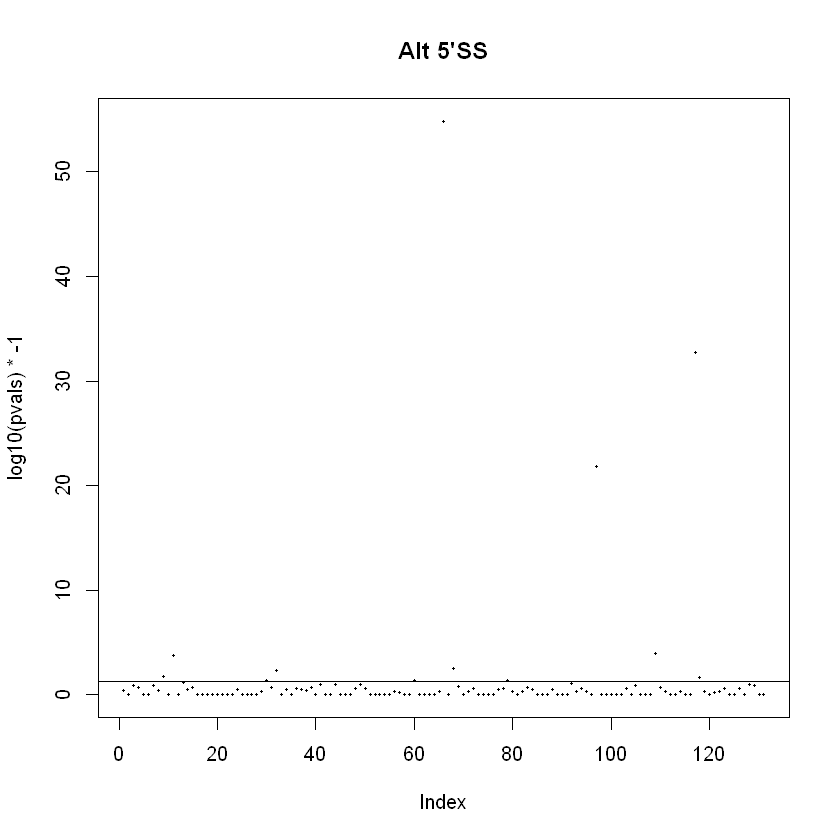

In [5]:
setwd('~/bme/jupyter_data')
mtaltrev = read.table('alt5primess_counts.txt')
mtalt = read.table('alt5primess_counts.rev.txt')  # 3' ss alterations on the minus strand
colnames(mtalt) = c('mtchrom', 'mt5', 'mt3', 'mtcounts')
colnames(mtaltrev) = c('mtchrom', 'mt5', 'mt3', 'mtcounts')
wtaltrev = read.table('alt5primess_counts.wt.txt')
wtalt = read.table('alt5primess_counts.wt.rev.txt')

wtalt$temp = wtalt[,2]  # switch columns just so I can reuse 3' alt ss code
wtalt[,2] = wtalt[,3]
wtalt[,3] = wtalt$temp

mtalt$temp = mtalt[,2]
mtalt[,2] = mtalt[,3]
mtalt[,3] = mtalt$temp

alljuncs = unique(c(paste0(mtalt[,2],'-',mtalt[,3]), paste0(wtalt[,2],'-', wtalt[,3]), paste0(mtaltrev[,2],'-',mtaltrev[,3]),
             paste0(wtaltrev[,2],'-',wtaltrev[,3])))  # coordinate 1 to coordinate 2
print(head(alljuncs))
junctions = data.frame(alljuncs)
junctions$intron5 = as.numeric(substr(alljuncs,1,regexpr('-', alljuncs)-1))
junctions$intron3 = as.numeric(substr(alljuncs,regexpr('-',alljuncs)+1,nchar(alljuncs)))
wtcounts = wtalt[,4][match(alljuncs, paste0(wtalt[,2],'-',wtalt[,3]))]
wtcounts[is.na(wtcounts)] = wtaltrev[,4][match(alljuncs, paste0(wtaltrev[,2],'-',wtaltrev[,3]))][is.na(wtcounts)]
junctions$wtcounts = wtcounts
junctions$wtcounts[is.na(junctions$wtcounts)] = 0

mtcounts = mtalt[,4][match(alljuncs, paste0(mtalt[,2],'-',mtalt[,3]))]
mtcounts[is.na(mtcounts)] = mtaltrev[,4][match(alljuncs, paste0(mtaltrev[,2],'-',mtaltrev[,3]))][is.na(mtcounts)]
junctions$mtcounts = mtcounts
junctions$mtcounts[is.na(junctions$mtcounts)] = 0

chrvec =  wtalt[,1][match(alljuncs, paste0(wtalt[,2],'-',wtalt[,3]))]
chrvec[is.na(chrvec)] = wtaltrev[,1][match(alljuncs, paste0(wtaltrev[,2],'-',wtaltrev[,3]))][is.na(chrvec)]
chrvec[is.na(chrvec)] = mtalt[,1][match(alljuncs, paste0(mtalt[,2],'-',mtalt[,3]))][is.na(chrvec)]
chrvec[is.na(chrvec)] = mtaltrev[,1][match(alljuncs, paste0(mtaltrev[,2],'-',mtaltrev[,3]))][is.na(chrvec)]
junctions$chr = chrvec
junctions = junctions[!is.na(chrvec),]

junctions = junctions[order(junctions[,2]),]
junctionsold = junctions
junctions[,5] = round(sum(junctions[,4])/sum(junctions[,5])*junctions[,5])
junctions = junctions[rowSums(junctionsold[,c(4,5)]) > 1,]

junctions[1:6,]  # data frame containing junction counts for both mutant and wildtype

current_gene = paste0(junctions[1,6],':',junctions[1,2])
info = junctions[1,]
genes = c()
pvals = c()
allpvals = c()
dpsi = c()
for (row in 2:nrow(junctions)) {
    nameinit = paste0(junctions[row,6],':',junctions[row, 2])
    if (nameinit != current_gene ) {
        if (nrow(info) > 1) {
            best_dpsi = 0
            best_pval = 1
            for (i in 1:(nrow(info)-1)) {
                for (j in (i+1):nrow(info)) {
                    ctable = matrix(unlist(c(info[c(i,j),4], info[c(i,j),5])), nrow=2)
                    if (sum(ctable) != 0) {
                        pval = fisher.test(ctable)$p.value
                        allpvals = c(allpvals, pval)
                        if (pval < best_pval) {
                            best_pval = pval
                            best_dpsi = abs(info[i, 4]/sum(info[c(i,j),4]) - info[i, 5]/sum(info[c(i,j),5]))
                        }
                    }
                }
            }
            genes = c(genes, current_gene)
            pvals = c(pvals, best_pval)
            dpsi = c(dpsi, best_dpsi)
            
        }
        current_gene = nameinit
        info = junctions[row,]
    } else {
        info = rbind(info, junctions[row,])
    }
}
plot(log10(pvals)*-1, pch=16, cex=0.3, main="Alt 5'SS")
abline(h=log10(0.05)*-1)

genes5 = genes
pvals5 = pvals
junctions5 = junctions
dpsi5=dpsi

There are more unique significant Alt3'SS than Alt5'SS events with and without FDR correction. <br>

In [10]:
length(unique(pvals5[pvals5<0.05]))  # number of significant alt 5'ss events
length(unique(pvals3[pvals3<0.05]))  # number of significant alt 3'ss events
pvals5adj = p.adjust(pvals5, method='fdr')
pvals3adj = p.adjust(pvals3, method='fdr')
length(unique(pvals5adj[pvals5adj<0.05]))  # number of significant alt 5' ss events after fdr correction
length(unique(pvals3adj[pvals3adj<0.05]))  # number of significant alt 3' ss events after fdr connection
length(unique(paste0(junctions5[,1],junctions5[,3])))  # number of alt 5' ss events
length(unique(paste0(junctions3[,1], junctions3[,2])))  # number of alt 3' ss events
df3 = data.frame(genes3, pvals3adj)
df5 = data.frame(genes5, pvals5adj)
cbind((df3[order(df3$pvals3adj),][1:20,]), data.frame(index=seq(1:20)), (df5[order(df5$pvals5adj),][1:20,]))

[1] 12

[1] 11

[1] 5

[1] 7

[1] 8032

[1] 7974

,genes3,pvals3adj,index,genes5,pvals5adj
857,chr14:105855499,1.600524e-19,1,chr19:48965896,1.912760e-53
165,chr9:19378727,1.193751e-18,2,chr5:150412644,1.112301e-31
482,chr19:48965896,2.323418e-16,3,chr14:105855499,6.245717e-21
992,chr5:150412644,3.652742e-11,4,chr7:142801407,3.899738e-03
211,chr6:24718559,1.525624e-03,5,chr10:3781660,4.779568e-03
994,chr5:150446821,6.480329e-03,6,chr12:53295619,7.660819e-02
1029,chr6:158770783,3.280996e-02,7,chr1:30757678,9.849624e-02
282,chr6:31355336,7.380490e-01,8,chr19:2269724,2.799145e-01
1,chr9:172100,1.000000e+00,9,chr5:150445628,3.528620e-01
2,chr11:209980,1.000000e+00,10,chr6:30490495,5.328025e-01


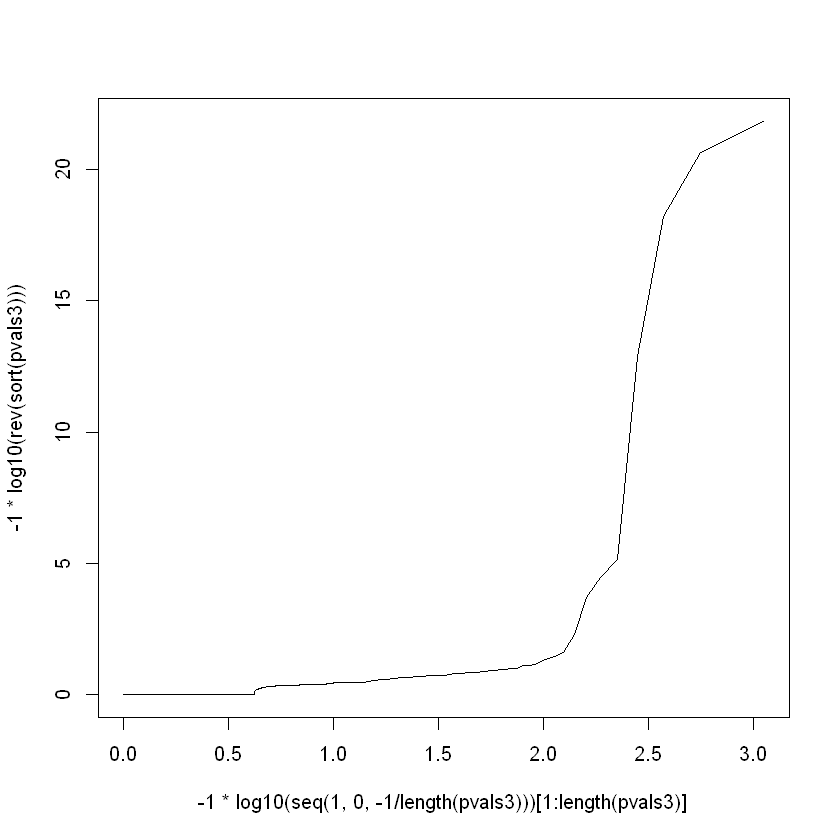

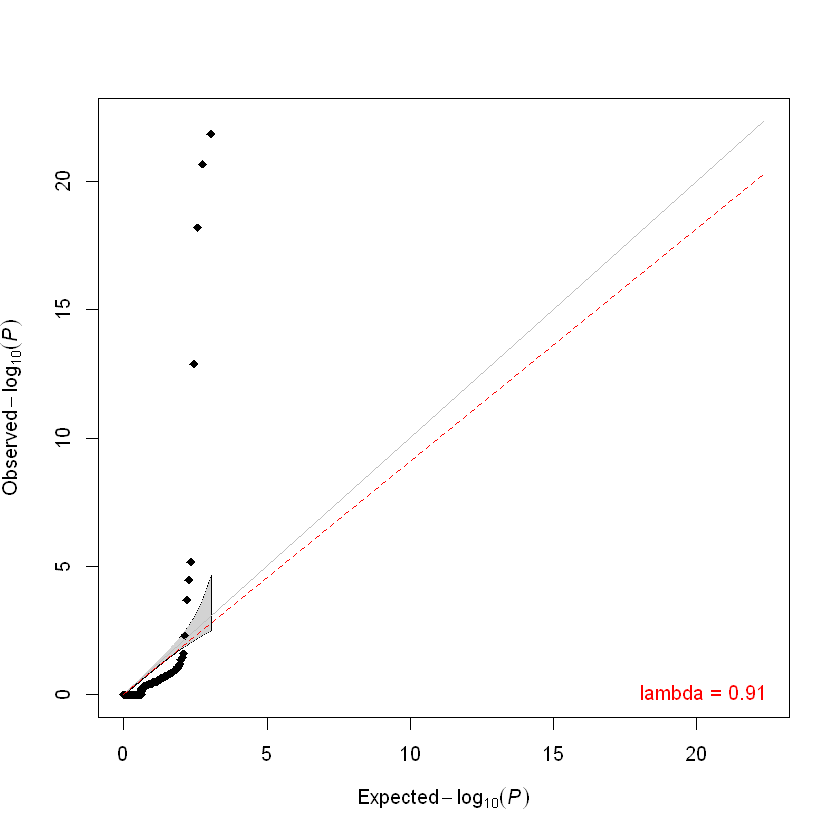

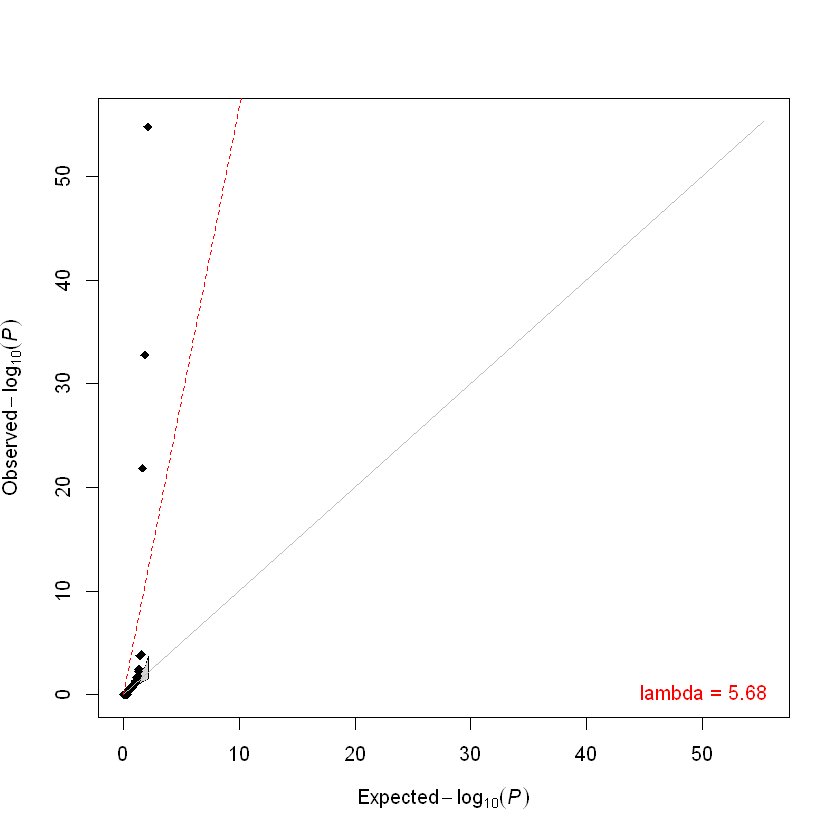

In [4]:
plot(-1*log10(seq(1,0,-1/length(pvals3)))[1:length(pvals3)],-1*log10(rev(sort(pvals3))),type='l')
source("~/bme/jupyter_data/qq_pval.r")
qq_pval(pvals3)
qq_pval(pvals5)

I decided to move all contingency table making and fisher testing into python for sake of time. I've put the accompanying script in the same github folder as these jupyter notebooks.
Changes from above implementations of fisher tests:
1. I use all junctions found in the corrected reads. Before I was using junctions that were novel to the corrected nanopore reads.
2. Contigency tables are formed with the counts in wildtype/mutant that are used by a junctionA and the sum of counts of all other junctions sharing the same 5' (or 3', when looking at alternative 5' splicing) as junctionA. Before I was doing pairwise comparisons.
3. The counts of wt or mt reads aligning to a junction must sum to at least 2 (arbitrary cutoff, can experiment). 

[1] 6680

[1] 5835

[1] 189

[1] 165

,V1,V2,V3,V4,V5,V6,V7,V8,V9,padj
1542,chr19,48965769,48965609,5.630790e-50,-,43,340,93,15,3.761368e-46
5106,chr19,48965916,48966280,1.057174e-42,+,70,334,77,4,3.530961e-39
5414,chr14,105856217,105863197,3.390310e-31,+,0,153,73,61,7.549090e-28
1539,chr19,48965769,48965606,7.123600e-30,-,47,0,89,355,1.189641e-26
4008,chr5,150412624,150407324,7.230162e-27,-,51,263,84,34,9.659497e-24
552,chr14,105855479,105855234,6.220972e-26,-,158,101,11,121,6.926016e-23


,V1,V2,V3,V4,V5,V6,V7,V8,V9,padj
4453,chr19,48965769,48965609,9.513888e-48,+,41,310,91,14,5.551354e-44
1860,chr5,150412624,150407324,6.010635e-37,+,50,318,80,19,1.753603e-33
4449,chr19,48965769,48965606,6.760458e-34,+,54,0,78,324,1.314909e-30
4862,chr14,105855479,105855234,3.459056e-31,+,150,99,4,122,5.045898e-28
469,chr14,105856217,105863197,4.291951e-30,-,1,131,73,46,5.008707e-27
1670,chr9,19378707,19378514,3.786684e-28,+,39,2,0,71,3.682550e-25


[1] 28

[1] 26

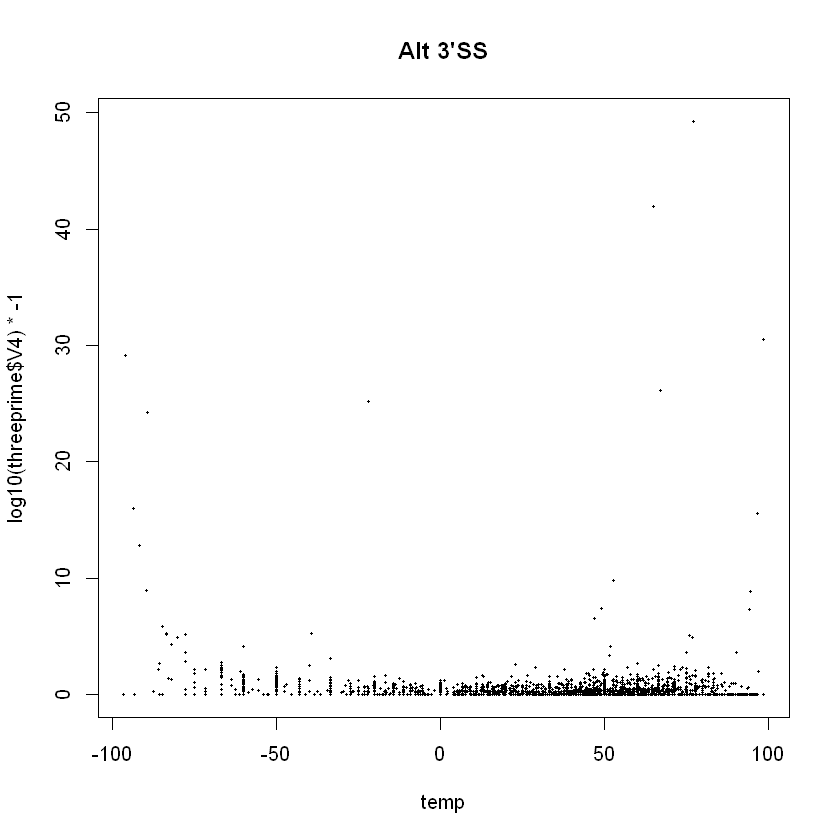

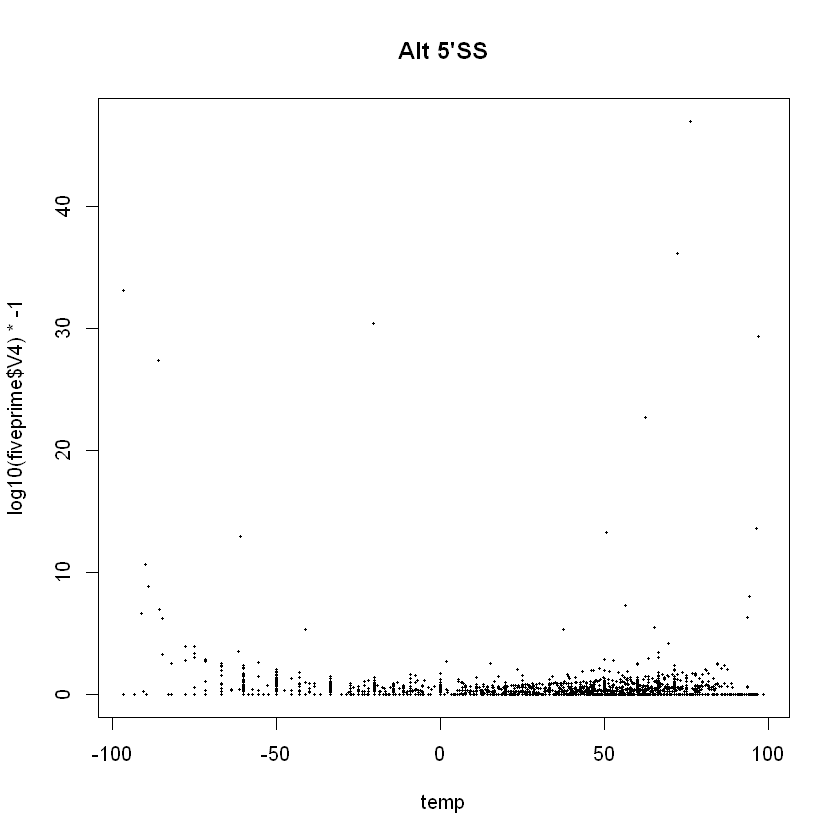

In [45]:
setwd('~/bme/jupyter_data/')
threeprime = read.table('alt3primess_fisher.txt')  # chrom, junction 5', 3', pval, strand, wt counts for this junction, 
                                                    # mt counts ' ', wt sum for all other junctions with this 5' position,
                                                    # mt sum ' '
fiveprime = read.table('alt5primess_fisher.txt')
nrow(threeprime)  # 3' total number of valid tests (counts >= 2)
nrow(fiveprime)  # 5' ""
sum(threeprime$V4 < 0.05)  # 3' tests that were significant
sum(fiveprime$V4 < 0.05)  # 5' ""
pvals3adj = p.adjust(threeprime$V4, method='fdr')
pvals5adj = p.adjust(fiveprime$V4, method='fdr')
threeprime$padj = pvals3adj
fiveprime$padj = pvals5adj
head(threeprime[order(threeprime$V4),])
head(fiveprime[order(fiveprime$V4),])
sum(pvals3adj < 0.05)  #  3' tests that were significant after correction
sum(pvals5adj < 0.05)  # 5' ""
temp = threeprime$V6+1
temp2 = threeprime$V7+1
temp = (temp2 - temp)/(temp2+temp)*100 # rough calculation of psi
plot(temp,log10(threeprime$V4)*-1, pch=16, cex=0.3, main="Alt 3'SS")  # a poor man's volcano plot
temp = fiveprime$V6+1
temp2 = fiveprime$V7+1
temp = (temp2 - temp)/(temp2+temp)*100
plot(temp,log10(fiveprime$V4)*-1, pch=16, cex=0.3, main="Alt 5'SS")

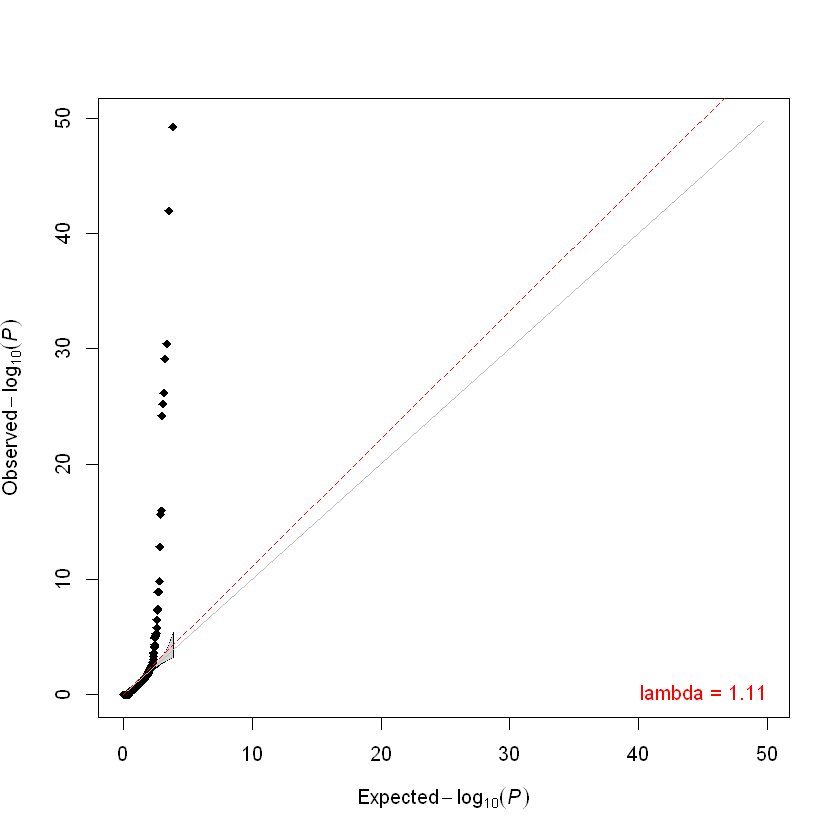

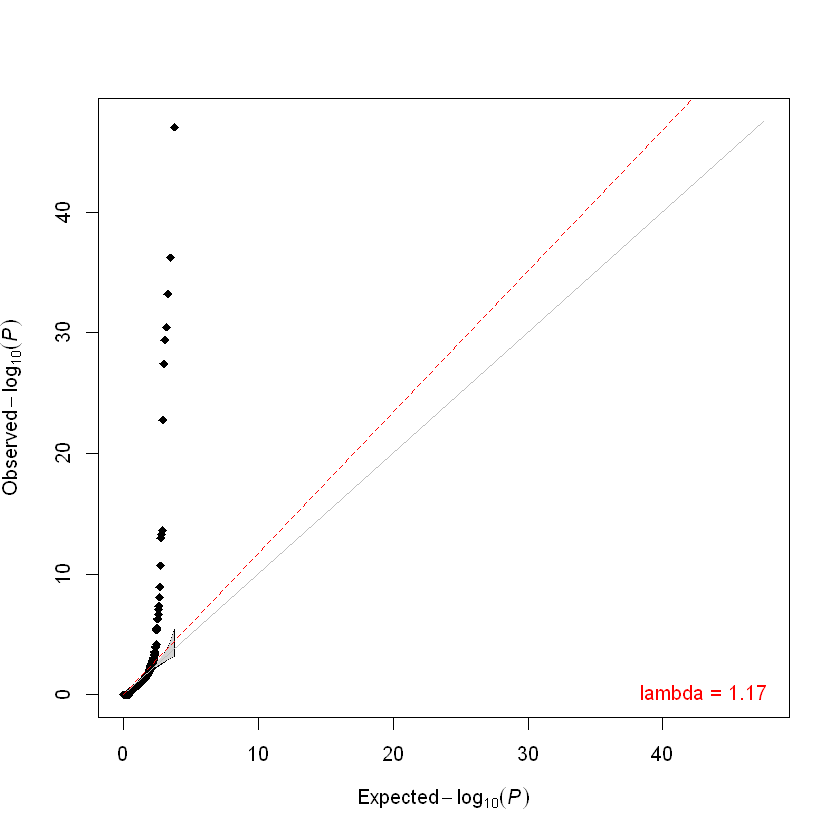

In [32]:
source("~/bme/jupyter_data/qq_pval.r")
qq_pval(threeprime$V4)
qq_pval(fiveprime$V4)

Ahh.. once again I fix the strand. Before I was using the strand that the read came from, which is not necessarily consistent with what strand the gene is on. It makes for poor fisher testing.

[1] 2492

[1] 5092

[1] 65

[1] 90

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,padj
1697,chr5,150412624,150407324,2.439924e-40,-,51,263,82,8,CD74,6.080290e-37
477,chr14,105855479,105855234,4.247743e-28,-,158,101,11,132,IGHM,5.292688e-25
1176,chr9,19378707,19378514,2.048377e-26,-,34,1,1,76,RPS6,1.701519e-23
480,chr14,105855479,105855238,1.056691e-15,-,0,58,169,175,IGHM,6.583186e-13
1584,chr6,31355316,31355223,2.356985e-12,-,7,60,28,7,HLA-B,1.174721e-09
1504,chr6,24718539,24716324,4.731716e-11,-,16,54,27,2,C6orf62,1.965239e-08


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,padj
3769,chr19,48965769,48965609,1.755952e-50,+,43,340,101,20,FTL,8.941307e-47
427,chr14,105856217,105863197,9.148395e-32,-,1,131,81,49,IGHM,2.329181e-28
3765,chr19,48965769,48965606,5.110666e-29,+,47,0,97,360,FTL,8.674504e-26
3764,chr19,48965769,48965604,3.149554e-13,+,22,0,122,360,FTL,4.009383e-10
431,chr14,105856217,105864214,1.327661e-12,-,32,7,50,173,IGHM,1.352090e-09
3432,chr2,88857683,88860885,9.272923e-08,-,85,3,18,15,IGKC,7.869621e-05


[1] 15

[1] 11

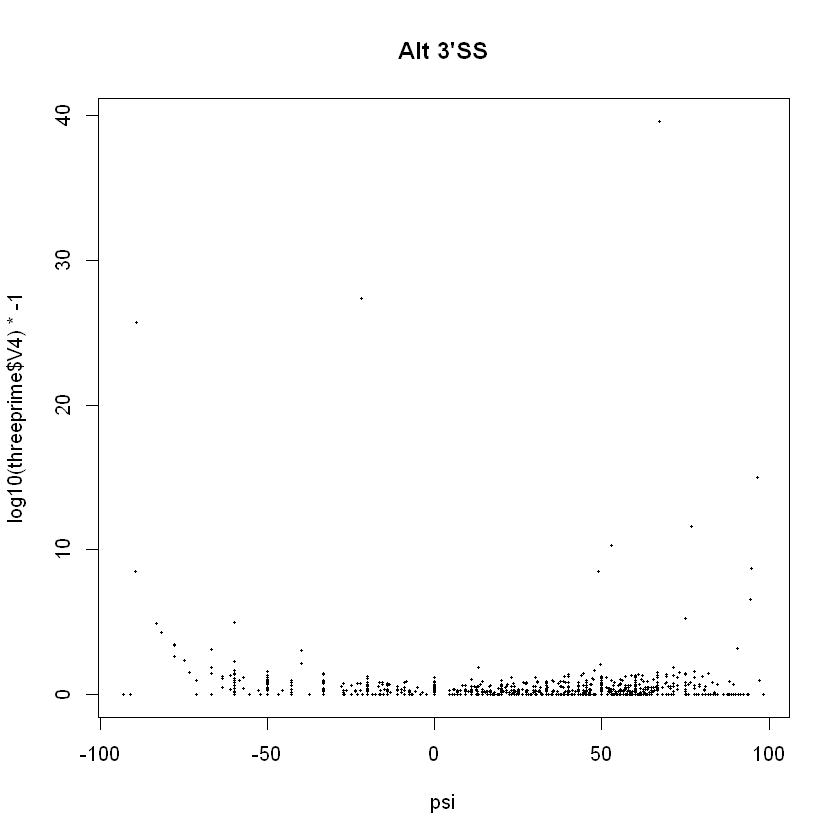

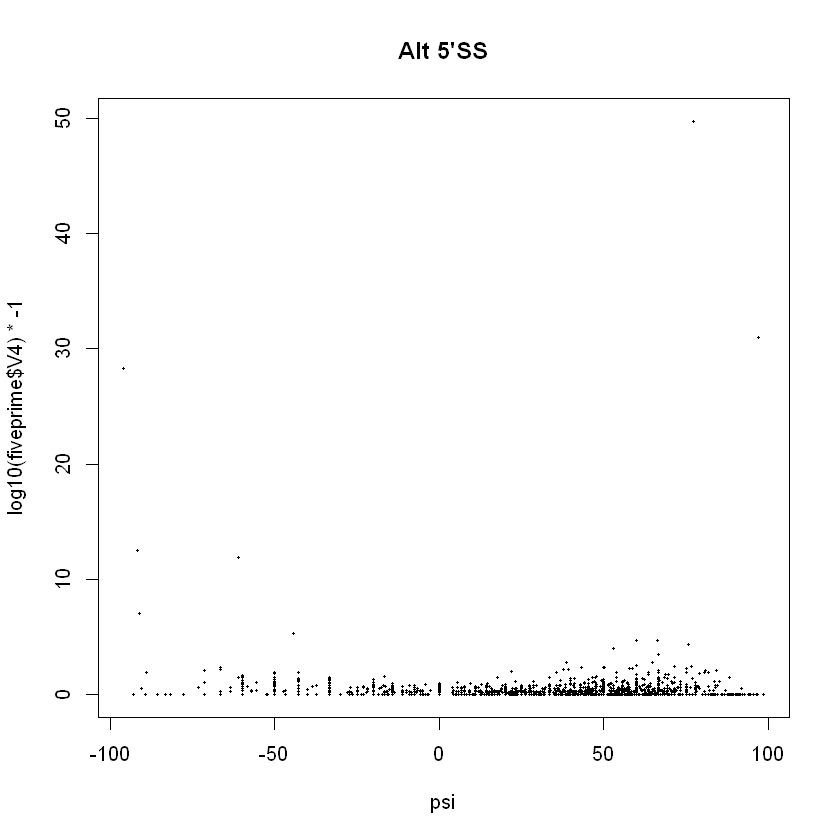

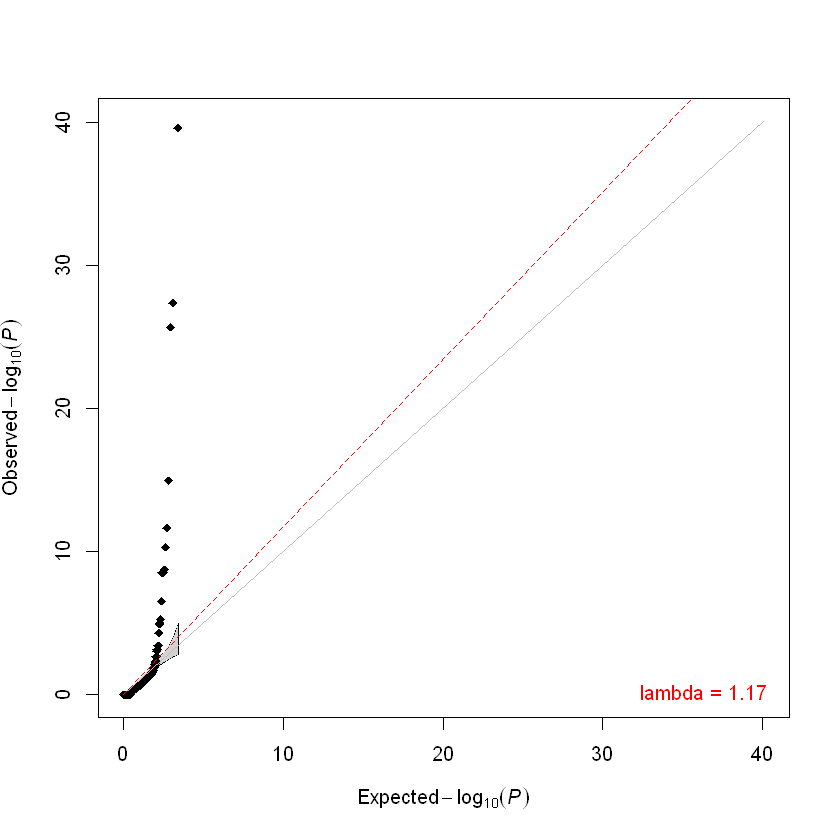

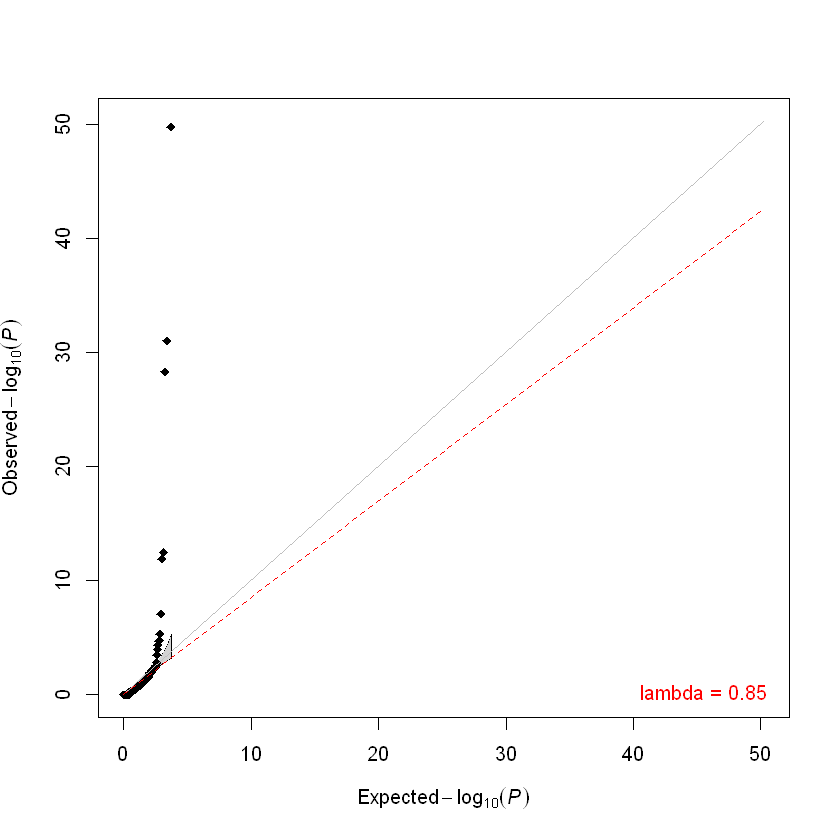

In [57]:
setwd('~/bme/jupyter_data/')
threeprime = read.table('alt3primess_strandfixed.txt')  # chrom, junction 5', 3', pval, strand, wt counts for this junction, 
                                                    # mt counts ' ', wt sum for all other junctions with this 5' position,
                                                    # mt sum ' '
fiveprime = read.table('alt5primess_strandfixed.txt')
nrow(threeprime)  # 3' total number of valid tests (counts >= 2)
nrow(fiveprime)  # 5' ""
sum(threeprime$V4 < 0.05)  # 3' tests that were significant
sum(fiveprime$V4 < 0.05)  # 5' ""
pvals3adj = p.adjust(threeprime$V4, method='fdr')
pvals5adj = p.adjust(fiveprime$V4, method='fdr')
threeprime$padj = pvals3adj
fiveprime$padj = pvals5adj
head(threeprime[order(threeprime$V4),])
head(fiveprime[order(fiveprime$V4),])
sum(pvals3adj < 0.05)  #  3' tests that were significant after correction
sum(pvals5adj < 0.05)  # 5' ""
psi = threeprime$V6+1
psi2 = threeprime$V7+1
psi = (psi2 - psi)/(psi2+psi)*100 # rough calculation of psi
plot(psi,log10(threeprime$V4)*-1, pch=16, cex=0.3, main="Alt 3'SS")  # a poor man's volcano plot
psi = fiveprime$V6+1
psi2 = fiveprime$V7+1
psi = (psi2 - psi)/(psi2+psi)*100
plot(psi,log10(fiveprime$V4)*-1, pch=16, cex=0.3, main="Alt 5'SS")
source("~/bme/jupyter_data/qq_pval.r")
qq_pval(threeprime$V4)
qq_pval(fiveprime$V4)